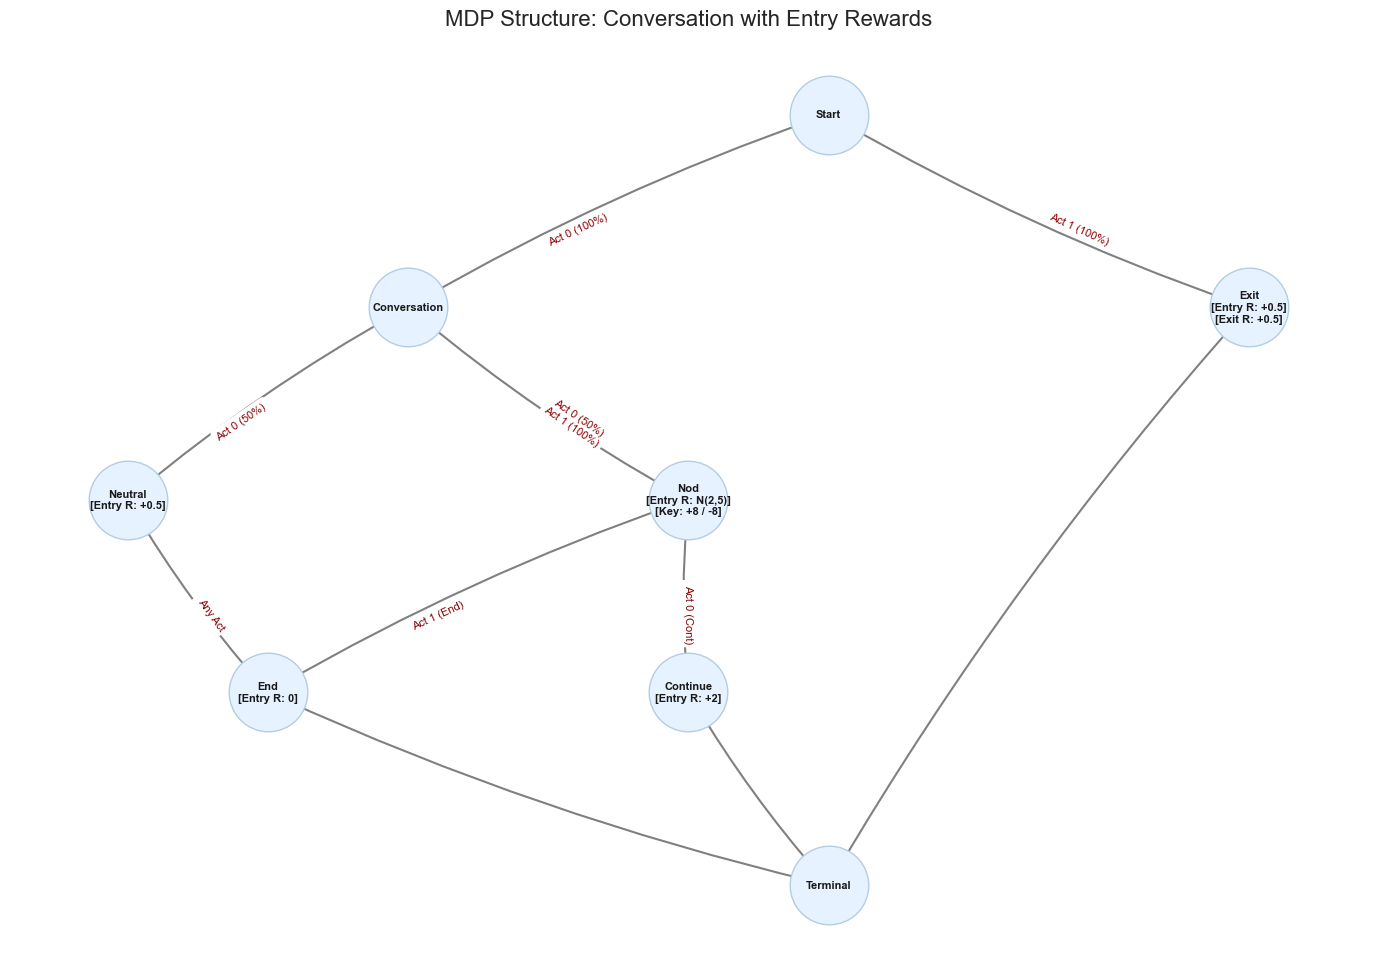

In [35]:
# ------------------------------------------------------------
# 5. VISUALIZATION FUNCTION (Paste this at the end)
# ------------------------------------------------------------
import networkx as nx

def visualize_mdp():
    """
    Plots the new "Conversation vs Exit" MDP structure.
    Visualizes rewards as Entry/Exit rewards within the nodes.
    """
    # 1. Define Nodes (States) with Reward info embedded
    node_labels = {
        0: "Start",
        
        # Level 1
        1: "Conversation",
        2: "Exit\n[Entry R: +0.5]\n[Exit R: +0.5]",
        
        # Level 2 (Reactions)
        3: "Neutral\n[Entry R: +0.5]",
        4: "Nod\n[Entry R: N(2,5)]\n[Key: +8 / -8]",
        
        # Level 3 (Outcomes)
        5: "Continue\n[Entry R: +2]",
        6: "End\n[Entry R: 0]",
        
        7: "Terminal"
    }

    # 2. Define Edges (Transitions)
    edges = [
        # Start -> Conversation / Exit
        (0, 1, "Act 0 (100%)"),
        (0, 2, "Act 1 (100%)"),
        
        # Exit -> Terminal
        (2, 7, ""),
        
        # Conversation -> Neutral / Nod
        (1, 3, "Act 0 (50%)"),       
        (1, 4, "Act 0 (50%)\nAct 1 (100%)"),
        
        # Neutral -> End
        (3, 6, "Any Act"),
        
        # Nod -> Continue / End
        (4, 5, "Act 0 (Cont)"),
        (4, 6, "Act 1 (End)"),
        
        # Outcomes -> Terminal
        (5, 7, ""),
        (6, 7, "")
    ]

    # 3. Build Graph
    G = nx.DiGraph()
    for n, label in node_labels.items():
        G.add_node(n, label=label)
    
    for u, v, label in edges:
        G.add_edge(u, v, label=label)

    # 4. Set Positions (Tree Layout)
    pos = {
        0: (0, 10),              # Start
        1: (-3, 8), 2: (3, 8),   # Level 1: Conversation vs Exit
        
        3: (-5, 6), 4: (-1, 6),  # Level 2: Neutral vs Nod
        
        5: (-1, 4), 6: (-4, 4),  # Level 3: Continue vs End
        
        7: (0, 2)                # Terminal
    }

    # 5. Draw
    plt.figure(figsize=(14, 10))
    
    # Draw Nodes
    nx.draw_networkx_nodes(G, pos, node_size=3200, node_color="#e6f2ff", edgecolors="#b3cde3")
    
    # Draw Labels
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_weight="bold")
    
    # Draw Edges
    nx.draw_networkx_edges(G, pos, edge_color="gray", arrows=True, arrowsize=20, width=1.5, connectionstyle='arc3,rad=0.05')
    
    # Draw Edge Labels
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.6, font_color="darkred")

    plt.title("MDP Structure: Conversation with Entry Rewards", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('mdp_structure_visual.png',dpi=300)
    plt.show()

# Run the visualization
visualize_mdp()

# Visualize Social MDP

Running Simulation...
ERROR! Session/line number was not unique in database. History logging moved to new session 162


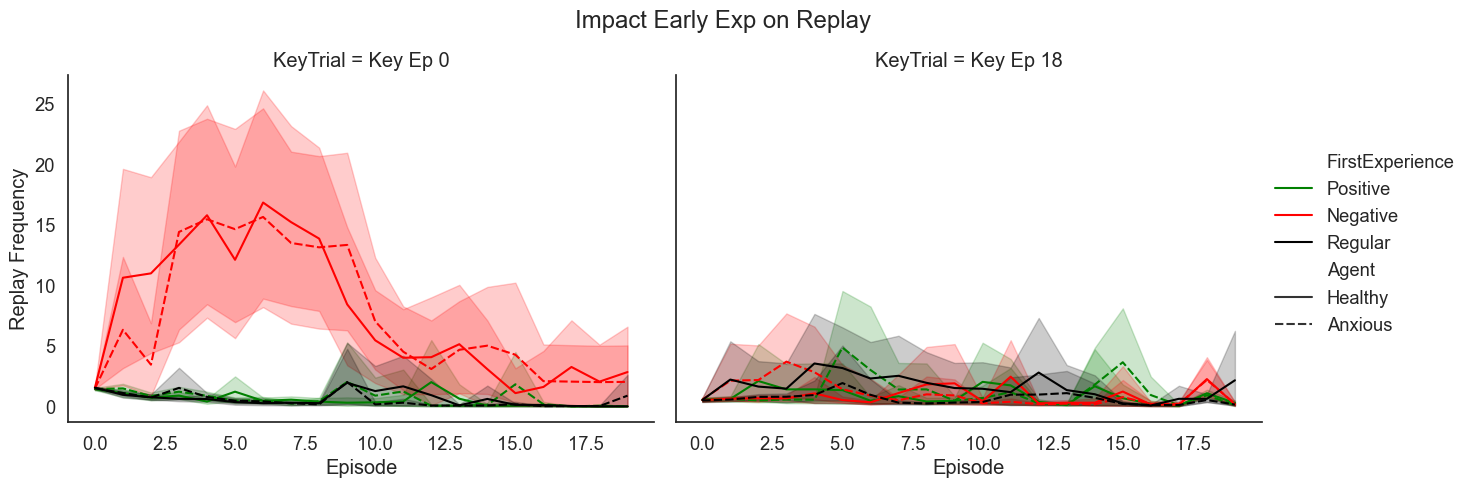

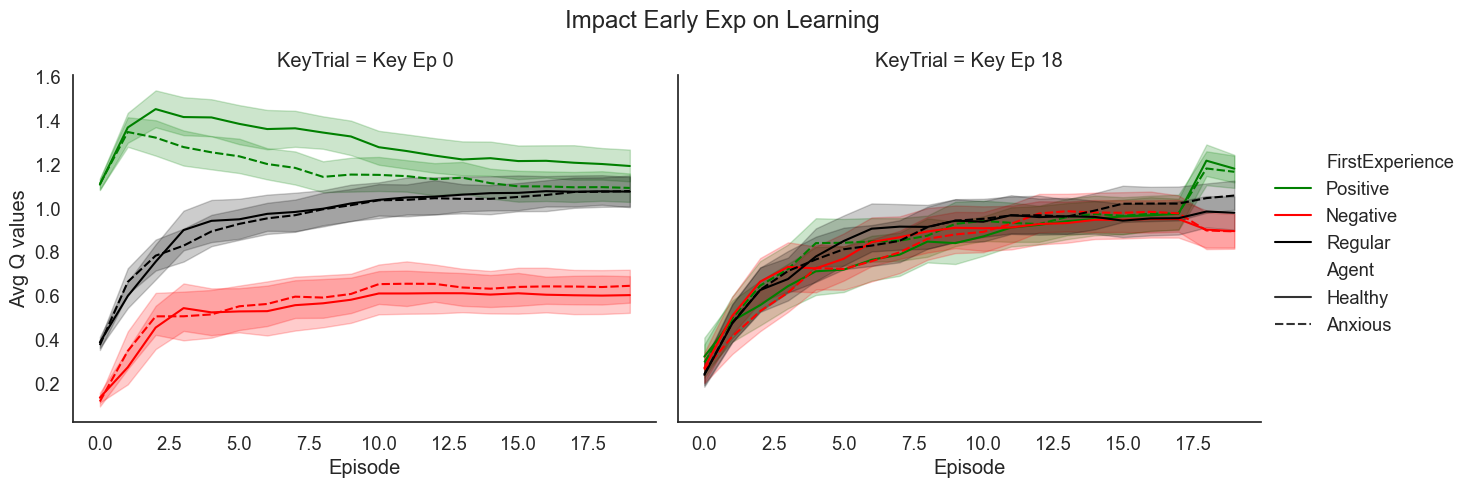

State Map:
0: Start
1: Conversation
2: Exit
3: Neutral
4: Nod
5: Continue
6: End
7: Terminal


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns 
import networkx as nx

sns.set(style="white", font_scale=1.2)

# ------------------------------------------------------------
# 0. Global Constants & State Definitions
# ------------------------------------------------------------

# State Mapping
STATE_START               = 0
STATE_START_CONVERSATION  = 1
STATE_RUN_AWAY            = 2

# Level 2 (Reactions)
STATE_NEUTRAL     = 3
STATE_NOD         = 4
STATE_CONTINUE    = 5
STATE_END         = 6

STATE_TERMINAL    = 7

N_STATES  = 8
N_ACTIONS = 2 

STATE_NAMES = {
    0: "Start", 1: "Conversation", 2: "Exit",
    3: "Neutral", 4: "Nod",
    5: "Continue", 6: "End",
    7: "Terminal"
}

# ------------------------------------------------------------
# 1. Helper Functions
# ------------------------------------------------------------

def softmax(q_values, beta):
    """Compute softmax probabilities."""
    e_x = np.exp(beta * (q_values - np.max(q_values)))
    return e_x / e_x.sum()

def get_next_state_and_reward(state, action, is_key_trial=False, force_outcome_neg=False,regular_trial=False):
    """
    Probabilistic Decision Tree Step.
    """
    next_state = state
    reward = 0.0
    
    # --- Level 0: Start -> Conversation or Exit ---
    if state == STATE_START:
        if action == 0:
            probs = [1, 0]
        else:
            probs = [0, 1]
        next_state = np.random.choice([STATE_START_CONVERSATION, STATE_RUN_AWAY], p=probs)
        
        if next_state == STATE_RUN_AWAY:
            reward = 0.5
        
    # --- Level 1: Conversation -> Reaction ---
    elif state == STATE_START_CONVERSATION:
        # Action 0: 50% Neutral, 50% Nod
        # Action 1: 100% Nod
        if action == 0: 
            next_state = np.random.choice([STATE_NEUTRAL, STATE_NOD], p=[0.5, 0.5])
        else:
            next_state = np.random.choice([STATE_NEUTRAL, STATE_NOD], p=[0, 1])

        if next_state == STATE_NOD:
            if is_key_trial and force_outcome_neg:
                reward = -8.0 # TRAUMA
            elif is_key_trial and not force_outcome_neg:
                if not regular_trial:
                    reward = 8.0
                else:
                    reward=2
            else:
                # Normal trials: Normal dist
                reward = np.random.normal(loc=2, scale=5)
        else:
            # Neutral outcome reward
            reward = 0.5
            
    elif state == STATE_RUN_AWAY:
        next_state = STATE_TERMINAL
        reward = 0.5
            
    # --- Level 2: Reaction -> Outcome ---
    elif state in [STATE_NOD, STATE_NEUTRAL]:
        
        if state == STATE_NOD:
            # Nod branch: Continue (Reward) or End (Zero)
            if action == 0:
                next_state = STATE_CONTINUE
                reward = 2.0
            else:
                next_state = STATE_END
                reward = 0.0
        else:
            # Neutral branch: Always ends
            next_state = STATE_END
            reward = 0.0

    # --- Level 3: Outcomes -> Terminal ---
    elif state in [STATE_CONTINUE, STATE_END]:
        next_state = STATE_TERMINAL
        reward = 0.0

    elif state == STATE_TERMINAL:
        next_state = STATE_TERMINAL
        reward = 0.0
        
    return next_state, reward

def step_explore_sr(state, action):
    """Simplified step for SR learning."""
    next_s, _ = get_next_state_and_reward(state, action)
    return next_s, 0

# ------------------------------------------------------------
# 2. Simulation Logic
# ------------------------------------------------------------

def simulate_condition(agent_type: str,
                       first_outcome: str,
                       key_trial_idx: int, 
                       tau: float = 0.1,
                       n_episodes: int = 20,
                       n_steps_explore: int = 200,
                       alpha: float = 0.1,
                       gam_anx: float = 0.40,
                       gam_healthy: float = 0.50,
                       gamma_learn: float = 0.9,
                       beta: float = 1.0,
                       burst_max: int = 50,
                       use_descending_lr: bool = True):
       
    # ---------- Initialise value and SR ----------------------
    Q  = np.zeros((N_STATES, N_ACTIONS))
    SR = np.eye(N_STATES) 
    
    update_counts_RWD = np.zeros((N_STATES, N_ACTIONS), dtype=int)
    update_counts_SR  = np.zeros(N_STATES, dtype=int)

    memory       = []
    memory_PEP   = [] 
    
    total_replay = 0
    total_reward = 0
    
    episode_stats = []
    
    def alpha_RWD(st, a):
        n = update_counts_RWD[st, a]
        return 1.0 if n == 0 else 1.0 / n

    # ---------- REPLAY LOGIC -------------------------
    def replay_burst(curr_state):
        n_burst = 0            
        V_cost  = np.dot(softmax(Q[curr_state], beta), Q[curr_state])
        
        nonlocal total_replay, gam_anx, gam_healthy
        while n_burst < burst_max:
            
            best_evb_c, best_mem = 0, 0
            memory_counter=0
            for (s_mem, a_mem, r_mem, s2_mem,td_mem) in memory:
                # SR lookup
                need    = SR[curr_state, s_mem] 
                q_old   = Q[s_mem, a_mem]
                td      = r_mem + gamma_learn * np.max(Q[s2_mem]) - q_old

                if use_descending_lr:
                    a_mem_lr = alpha_RWD(s_mem, a_mem)
                else:
                    a_mem_lr = alpha
                q_new = q_old + a_mem_lr * td

                q_tmp          = Q[s_mem].copy()
                q_tmp_old      = Q[s_mem].copy()
                q_tmp[a_mem]   = q_new
                new_policy_v   = np.dot(softmax(q_tmp, beta), q_tmp)
                old_policy_v   = np.dot(softmax(Q[s_mem], beta), q_tmp_old)
                
                # EVB Calculation
                evb_c = np.abs(a_mem_lr*td_mem)-(old_policy_v/5)
                
                if evb_c > best_evb_c:
                    best_evb_c, best_mem = evb_c, (s_mem, a_mem, q_new, r_mem)
                    best_mem_counter=memory_counter
                memory_counter+=1
                
            eps = 0.5
            if best_evb_c <= 0 + eps:
                break
                
            s_b, a_b, q_new_b, r_b = best_mem
            if use_descending_lr:
                update_counts_RWD[s_b, a_b] += 1
            Q[s_b, a_b] = q_new_b
        
            my_list = list(memory[best_mem_counter])  
            my_list[4] = td
            new_memory = tuple(my_list) 
            memory[best_mem_counter]=new_memory
            total_replay += 1
            n_burst += 1

    def replay_burst_PEP(specific_memory):
        n_burst = 0              
          
        nonlocal total_replay, gam_anx, gam_healthy
        while n_burst < burst_max:
              
            s_mem, a_mem, r_mem, s2_mem,td_mem = specific_memory
   
            q_old   = Q[s_mem, a_mem]
            
            td      = r_mem + gamma_learn * np.max(Q[s2_mem]) - q_old

            if use_descending_lr:
                a_mem_lr = alpha_RWD(s_mem, a_mem)
            else:
                a_mem_lr = alpha
              
            q_new = q_old + a_mem_lr * td

            q_tmp          = Q[s_mem].copy()
            q_valueOld     = np.dot(softmax(Q[s_mem],beta),q_tmp)
            
            evb_c = np.abs(a_mem_lr*td)-(q_valueOld/5)

            best_mem = (s_mem, a_mem, q_new, r_mem)
           
            eps = 0
            if evb_c <= 0 + eps:
                break
            s_b, a_b, q_new_b, r_b = best_mem
            if use_descending_lr:
                update_counts_RWD[s_b, a_b] += 1
            Q[s_b, a_b] = q_new_b
              
            total_replay += 1
            n_burst += 1

    # ----------------------------------------------------------
    # Pre-training SR
    # ----------------------------------------------------------
    s_t = STATE_START
    for _ in range(n_steps_explore):
        a_t = np.random.choice(N_ACTIONS)
        s_next, _ = step_explore_sr(s_t, a_t)
        
        lr = alpha 
        one_hot = np.zeros(N_STATES)
        one_hot[s_t] = 1.0
        SR[s_t, :] += lr * (one_hot + gamma_learn * SR[s_next, :] - SR[s_t, :])
        
        if s_next == STATE_TERMINAL:
            s_t = STATE_START
        else:
            s_t = s_next

    # ----------------------------------------------------------
    # Main Online Episodes
    # ----------------------------------------------------------
    for e in range(n_episodes):
        start_replay_count = total_replay
        s_t = STATE_START
        
        is_key_ep = (e == key_trial_idx)
        
        ep_reward = 0
        step_count = 0
        
        while s_t != STATE_TERMINAL and step_count < 10:
            step_count += 1
            
            # Action Selection
            q_vals = Q[s_t]
            p_vals = softmax(q_vals, beta)
            a_t = np.random.choice(N_ACTIONS, p=p_vals)
            
            # --- Key Trial Manipulation ---
            force_neg = False
            reg_trial=False
            if is_key_ep and first_outcome == "Negative":
                force_neg = True
                if s_t == STATE_START:
                    a_t = 0 # Force Convo (Group 1)
                if s_t == STATE_START_CONVERSATION:
                    a_t = 1 # Force Joke -> High Prob of Nod
            
            if is_key_ep and first_outcome == "Positive":
                if s_t == STATE_START:
                    a_t = 0 # Force Convo (Group 1)
                if s_t == STATE_START_CONVERSATION:
                    a_t = 1 # Force Joke -> High Prob of Nod
            if is_key_ep and first_outcome == "Regular":
                reg_trial=True
                if s_t == STATE_START:
                    a_t = 0 # Force Convo (Group 1)
                if s_t == STATE_START_CONVERSATION:
                    a_t = 1 # Force Joke -> High Prob of Nod
            
            # Execute Step
            s_next, r_t = get_next_state_and_reward(s_t, a_t, is_key_trial=is_key_ep, force_outcome_neg=force_neg,regular_trial=reg_trial)
            
            # Learning
            if use_descending_lr:
                update_counts_RWD[s_t, a_t] += 1
                a_lr = alpha_RWD(s_t, a_t)
            else:
                a_lr = alpha

            td = r_t + (gamma_learn * np.max(Q[s_next])) - Q[s_t, a_t]
            Q[s_t, a_t] += a_lr * td
            
            # Memory
            memory.append((s_t, a_t, r_t, s_next, td))
            memory = memory[-25:] 
            
            # --- Replay ---
            replay_burst(s_t)

            # --- PEP Replay ---
            q_tmp_old = Q[s_t].copy()
            old_policy_v = np.dot(softmax(Q[s_t], beta), q_tmp_old)
            evb_c = np.abs(a_lr*td)-(old_policy_v/5)
            if evb_c > 0.1: 
                memory_PEP.append((s_t, a_t, r_t, s_next, td))
            
            ep_reward += r_t
            s_t = s_next
            
        # Stats
        avg_q = np.mean(np.max(Q, axis=1))
        replays_in_ep = total_replay - start_replay_count
        episode_stats.append({
            'Episode': e,
            'Replays': replays_in_ep,
            'AvgQ': avg_q,
            'TotalReward': ep_reward
        })

    return episode_stats


# ------------------------------------------------------------
# 3. Parameter Sweep & Execution
# ------------------------------------------------------------

key_episodes_to_test = [0, 18]
n_eps = 20
n_runs = 100
scenarios = [
    ("Healthy", "Positive"), 
    ("Healthy", "Negative"),
    ("Healthy", "Regular"),
    ("Anxious", "Positive"), 
    ("Anxious", "Negative"),
    ("Anxious", "Regular")
]

episode_records = []

print("Running Simulation...")

for kt in key_episodes_to_test:
    for run in range(n_runs):
        for agent, first_exp in scenarios:
            ep_stats = simulate_condition(
                agent_type=agent,
                first_outcome=first_exp,
                key_trial_idx=kt,
                n_episodes=n_eps 
            )
            
            for stat in ep_stats:
                episode_records.append({
                    'KeyTrial': f"Key Ep {kt}",
                    'Agent': agent,
                    'FirstExperience': first_exp,
                    'Run': run,
                    'Episode': stat['Episode'],
                    'Replays': stat['Replays'],
                    'AvgQ': stat['AvgQ'],
                    'TotalReward': stat['TotalReward']
                })

df_episodes = pd.DataFrame(episode_records)

# ------------------------------------------------------------
# 4. Plotting
# ------------------------------------------------------------

g = sns.FacetGrid(df_episodes, col="KeyTrial", height=5, aspect=1.3)
def plot_replays(**kwargs):
    sns.lineplot(
        x='Episode', y='Replays', hue='FirstExperience', style='Agent',
        palette={'Positive': 'green', 'Negative': 'red','Regular':'black'}, **kwargs
    )
g.map_dataframe(plot_replays)
g.set_axis_labels("Episode", "Replay Frequency")
g.add_legend()
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Impact Early Exp on Replay")
plt.savefig('replays_socialexperience.png',dpi=300)
plt.show()

g2 = sns.FacetGrid(df_episodes, col="KeyTrial", height=5, aspect=1.3)
def plot_rewards(**kwargs):
    sns.lineplot(
        x='Episode', y='AvgQ', hue='FirstExperience', style='Agent',
        palette={'Positive': 'green', 'Negative': 'red','Regular':'black'}, **kwargs
    )
g2.map_dataframe(plot_rewards)
g2.set_axis_labels("Episode", "Avg Q values")
g2.add_legend()
plt.subplots_adjust(top=0.85)
g2.fig.suptitle("Impact Early Exp on Learning")
plt.savefig('qvalues_socialexperience.png',dpi=300)

plt.show()

print("State Map:")
for k, v in STATE_NAMES.items():
    print(f"{k}: {v}")


# Without descending learning rate

Running Simulation...


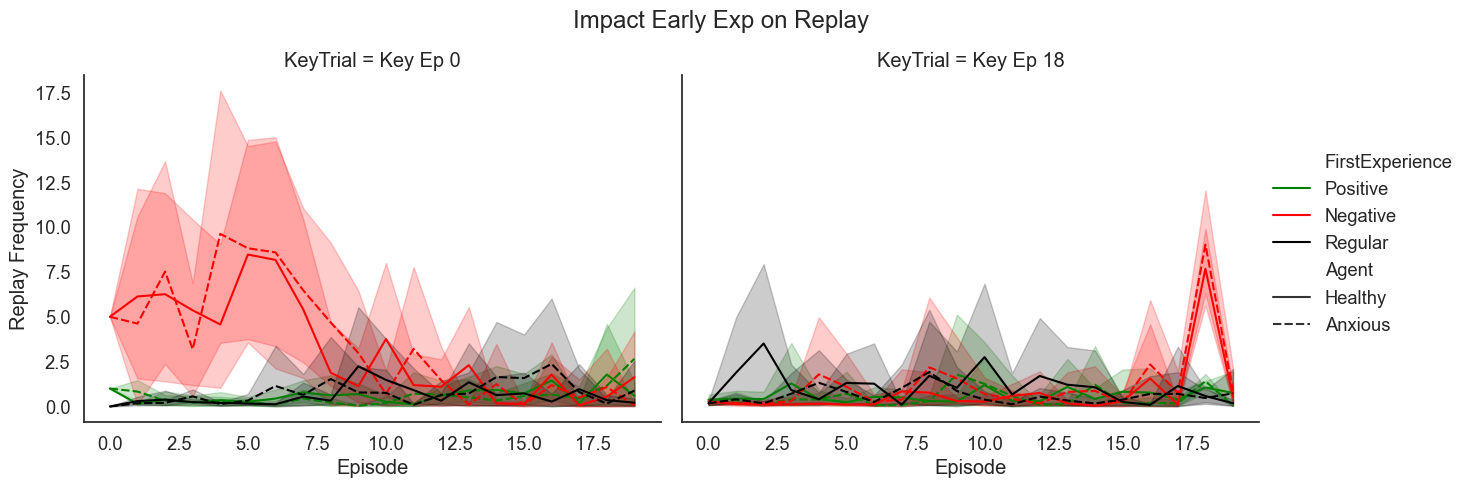

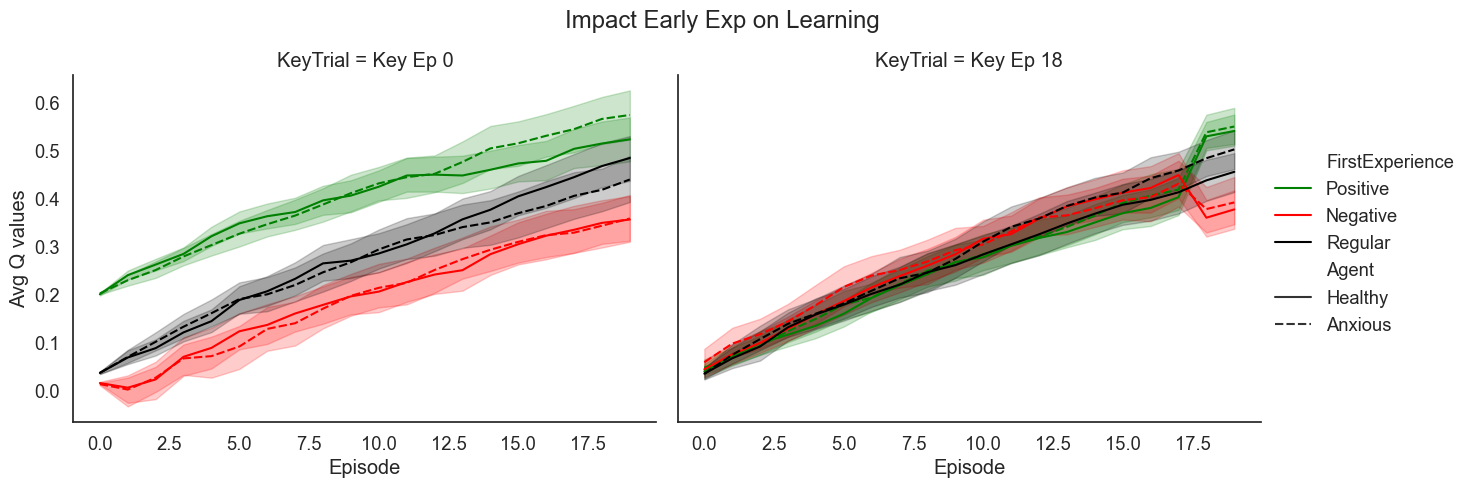

State Map:
0: Start
1: Conversation
2: Exit
3: Neutral
4: Nod
5: Continue
6: End
7: Terminal


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns 
import networkx as nx

sns.set(style="white", font_scale=1.2)

# ------------------------------------------------------------
# 0. Global Constants & State Definitions
# ------------------------------------------------------------

# State Mapping
STATE_START               = 0
STATE_START_CONVERSATION  = 1
STATE_RUN_AWAY            = 2

# Level 2 (Reactions)
STATE_NEUTRAL     = 3
STATE_NOD         = 4
STATE_CONTINUE    = 5
STATE_END         = 6

STATE_TERMINAL    = 7

N_STATES  = 8
N_ACTIONS = 2 

STATE_NAMES = {
    0: "Start", 1: "Conversation", 2: "Exit",
    3: "Neutral", 4: "Nod",
    5: "Continue", 6: "End",
    7: "Terminal"
}

# ------------------------------------------------------------
# 1. Helper Functions
# ------------------------------------------------------------

def softmax(q_values, beta):
    """Compute softmax probabilities."""
    e_x = np.exp(beta * (q_values - np.max(q_values)))
    return e_x / e_x.sum()

def get_next_state_and_reward(state, action, is_key_trial=False, force_outcome_neg=False,regular_trial=False):
    """
    Probabilistic Decision Tree Step.
    """
    next_state = state
    reward = 0.0
    
    # --- Level 0: Start -> Conversation or Exit ---
    if state == STATE_START:
        if action == 0:
            probs = [1, 0]
        else:
            probs = [0, 1]
        next_state = np.random.choice([STATE_START_CONVERSATION, STATE_RUN_AWAY], p=probs)
        
        if next_state == STATE_RUN_AWAY:
            reward = 0.5
        
    # --- Level 1: Conversation -> Reaction ---
    elif state == STATE_START_CONVERSATION:
        # Action 0: 50% Neutral, 50% Nod
        # Action 1: 100% Nod
        if action == 0: 
            next_state = np.random.choice([STATE_NEUTRAL, STATE_NOD], p=[0.5, 0.5])
        else:
            next_state = np.random.choice([STATE_NEUTRAL, STATE_NOD], p=[0, 1])

        if next_state == STATE_NOD:
            if is_key_trial and force_outcome_neg:
                reward = -8.0 # TRAUMA
            elif is_key_trial and not force_outcome_neg:
                if not regular_trial:
                    reward = 8.0
                else:
                    reward=2
            else:
                # Normal trials: Normal dist
                reward = np.random.normal(loc=2, scale=5)
        else:
            # Neutral outcome reward
            reward = 0.5
            
    elif state == STATE_RUN_AWAY:
        next_state = STATE_TERMINAL
        reward = 0.5
            
    # --- Level 2: Reaction -> Outcome ---
    elif state in [STATE_NOD, STATE_NEUTRAL]:
        
        if state == STATE_NOD:
            # Nod branch: Continue (Reward) or End (Zero)
            if action == 0:
                next_state = STATE_CONTINUE
                reward = 2.0
            else:
                next_state = STATE_END
                reward = 0.0
        else:
            # Neutral branch: Always ends
            next_state = STATE_END
            reward = 0.0

    # --- Level 3: Outcomes -> Terminal ---
    elif state in [STATE_CONTINUE, STATE_END]:
        next_state = STATE_TERMINAL
        reward = 0.0

    elif state == STATE_TERMINAL:
        next_state = STATE_TERMINAL
        reward = 0.0
        
    return next_state, reward

def step_explore_sr(state, action):
    """Simplified step for SR learning."""
    next_s, _ = get_next_state_and_reward(state, action)
    return next_s, 0

# ------------------------------------------------------------
# 2. Simulation Logic
# ------------------------------------------------------------

def simulate_condition(agent_type: str,
                       first_outcome: str,
                       key_trial_idx: int, 
                       tau: float = 0.1,
                       n_episodes: int = 20,
                       n_steps_explore: int = 200,
                       alpha: float = 0.1,
                       gam_anx: float = 0.40,
                       gam_healthy: float = 0.50,
                       gamma_learn: float = 0.9,
                       beta: float = 1.0,
                       burst_max: int = 50,
                       use_descending_lr: bool = False):
       
    # ---------- Initialise value and SR ----------------------
    Q  = np.zeros((N_STATES, N_ACTIONS))
    SR = np.eye(N_STATES) 
    
    update_counts_RWD = np.zeros((N_STATES, N_ACTIONS), dtype=int)
    update_counts_SR  = np.zeros(N_STATES, dtype=int)

    memory       = []
    memory_PEP   = [] 
    
    total_replay = 0
    total_reward = 0
    
    episode_stats = []
    
    def alpha_RWD(st, a):
        n = update_counts_RWD[st, a]
        return 1.0 if n == 0 else 1.0 / n

    # ---------- REPLAY LOGIC -------------------------
    def replay_burst(curr_state):
        n_burst = 0            
        V_cost  = np.dot(softmax(Q[curr_state], beta), Q[curr_state])
        
        nonlocal total_replay, gam_anx, gam_healthy
        while n_burst < burst_max:
            
            best_evb_c, best_mem = 0, 0
            memory_counter=0
            for (s_mem, a_mem, r_mem, s2_mem,td_mem) in memory:
                # SR lookup
                need    = SR[curr_state, s_mem] 
                q_old   = Q[s_mem, a_mem]
                td      = r_mem + gamma_learn * np.max(Q[s2_mem]) - q_old

                if use_descending_lr:
                    a_mem_lr = alpha_RWD(s_mem, a_mem)
                else:
                    a_mem_lr = alpha
                q_new = q_old + a_mem_lr * td

                q_tmp          = Q[s_mem].copy()
                q_tmp_old      = Q[s_mem].copy()
                q_tmp[a_mem]   = q_new
                new_policy_v   = np.dot(softmax(q_tmp, beta), q_tmp)
                old_policy_v   = np.dot(softmax(Q[s_mem], beta), q_tmp_old)
                
                # EVB Calculation
                evb_c = np.abs(a_mem_lr*td_mem)-(old_policy_v/5)
                
                if evb_c > best_evb_c:
                    best_evb_c, best_mem = evb_c, (s_mem, a_mem, q_new, r_mem)
                    best_mem_counter=memory_counter
                memory_counter+=1
                
            eps = 0.5
            if best_evb_c <= 0 + eps:
                break
                
            s_b, a_b, q_new_b, r_b = best_mem
            if use_descending_lr:
                update_counts_RWD[s_b, a_b] += 1
            Q[s_b, a_b] = q_new_b
        
            my_list = list(memory[best_mem_counter])  
            my_list[4] = td
            new_memory = tuple(my_list) 
            memory[best_mem_counter]=new_memory
            total_replay += 1
            n_burst += 1

    def replay_burst_PEP(specific_memory):
        n_burst = 0              
          
        nonlocal total_replay, gam_anx, gam_healthy
        while n_burst < burst_max:
              
            s_mem, a_mem, r_mem, s2_mem,td_mem = specific_memory
   
            q_old   = Q[s_mem, a_mem]
            
            td      = r_mem + gamma_learn * np.max(Q[s2_mem]) - q_old

            if use_descending_lr:
                a_mem_lr = alpha_RWD(s_mem, a_mem)
            else:
                a_mem_lr = alpha
              
            q_new = q_old + a_mem_lr * td

            q_tmp          = Q[s_mem].copy()
            q_valueOld     = np.dot(softmax(Q[s_mem],beta),q_tmp)
            
            evb_c = np.abs(a_mem_lr*td)-(q_valueOld/5)

            best_mem = (s_mem, a_mem, q_new, r_mem)
           
            eps = 0
            if evb_c <= 0 + eps:
                break
            s_b, a_b, q_new_b, r_b = best_mem
            if use_descending_lr:
                update_counts_RWD[s_b, a_b] += 1
            Q[s_b, a_b] = q_new_b
              
            total_replay += 1
            n_burst += 1

    # ----------------------------------------------------------
    # Pre-training SR
    # ----------------------------------------------------------
    s_t = STATE_START
    for _ in range(n_steps_explore):
        a_t = np.random.choice(N_ACTIONS)
        s_next, _ = step_explore_sr(s_t, a_t)
        
        lr = alpha 
        one_hot = np.zeros(N_STATES)
        one_hot[s_t] = 1.0
        SR[s_t, :] += lr * (one_hot + gamma_learn * SR[s_next, :] - SR[s_t, :])
        
        if s_next == STATE_TERMINAL:
            s_t = STATE_START
        else:
            s_t = s_next

    # ----------------------------------------------------------
    # Main Online Episodes
    # ----------------------------------------------------------
    for e in range(n_episodes):
        start_replay_count = total_replay
        s_t = STATE_START
        
        is_key_ep = (e == key_trial_idx)
        
        ep_reward = 0
        step_count = 0
        
        while s_t != STATE_TERMINAL and step_count < 10:
            step_count += 1
            
            # Action Selection
            q_vals = Q[s_t]
            p_vals = softmax(q_vals, beta)
            a_t = np.random.choice(N_ACTIONS, p=p_vals)
            
            # --- Key Trial Manipulation ---
            force_neg = False
            reg_trial=False
            if is_key_ep and first_outcome == "Negative":
                force_neg = True
                if s_t == STATE_START:
                    a_t = 0 # Force Convo (Group 1)
                if s_t == STATE_START_CONVERSATION:
                    a_t = 1 # Force Joke -> High Prob of Nod
            
            if is_key_ep and first_outcome == "Positive":
                if s_t == STATE_START:
                    a_t = 0 # Force Convo (Group 1)
                if s_t == STATE_START_CONVERSATION:
                    a_t = 1 # Force Joke -> High Prob of Nod
            if is_key_ep and first_outcome == "Regular":
                reg_trial=True
                if s_t == STATE_START:
                    a_t = 0 # Force Convo (Group 1)
                if s_t == STATE_START_CONVERSATION:
                    a_t = 1 # Force Joke -> High Prob of Nod
            
            # Execute Step
            s_next, r_t = get_next_state_and_reward(s_t, a_t, is_key_trial=is_key_ep, force_outcome_neg=force_neg,regular_trial=reg_trial)
            
            # Learning
            if use_descending_lr:
                update_counts_RWD[s_t, a_t] += 1
                a_lr = alpha_RWD(s_t, a_t)
            else:
                a_lr = alpha

            td = r_t + (gamma_learn * np.max(Q[s_next])) - Q[s_t, a_t]
            Q[s_t, a_t] += a_lr * td
            
            # Memory
            memory.append((s_t, a_t, r_t, s_next, td))
            memory = memory[-25:] 
            
            # --- Replay ---
            replay_burst(s_t)

            # --- PEP Replay ---
            q_tmp_old = Q[s_t].copy()
            old_policy_v = np.dot(softmax(Q[s_t], beta), q_tmp_old)
            evb_c = np.abs(a_lr*td)-(old_policy_v/5)
            if evb_c > 0.1: 
                memory_PEP.append((s_t, a_t, r_t, s_next, td))
            
            ep_reward += r_t
            s_t = s_next
            
        # Stats
        avg_q = np.mean(np.max(Q, axis=1))
        replays_in_ep = total_replay - start_replay_count
        episode_stats.append({
            'Episode': e,
            'Replays': replays_in_ep,
            'AvgQ': avg_q,
            'TotalReward': ep_reward
        })

    return episode_stats


# ------------------------------------------------------------
# 3. Parameter Sweep & Execution
# ------------------------------------------------------------

key_episodes_to_test = [0, 18]
n_eps = 20
n_runs = 100
scenarios = [
    ("Healthy", "Positive"), 
    ("Healthy", "Negative"),
    ("Healthy", "Regular"),
    ("Anxious", "Positive"), 
    ("Anxious", "Negative"),
    ("Anxious", "Regular")
]

episode_records = []

print("Running Simulation...")

for kt in key_episodes_to_test:
    for run in range(n_runs):
        for agent, first_exp in scenarios:
            ep_stats = simulate_condition(
                agent_type=agent,
                first_outcome=first_exp,
                key_trial_idx=kt,
                n_episodes=n_eps 
            )
            
            for stat in ep_stats:
                episode_records.append({
                    'KeyTrial': f"Key Ep {kt}",
                    'Agent': agent,
                    'FirstExperience': first_exp,
                    'Run': run,
                    'Episode': stat['Episode'],
                    'Replays': stat['Replays'],
                    'AvgQ': stat['AvgQ'],
                    'TotalReward': stat['TotalReward']
                })

df_episodes = pd.DataFrame(episode_records)

# ------------------------------------------------------------
# 4. Plotting
# ------------------------------------------------------------

g = sns.FacetGrid(df_episodes, col="KeyTrial", height=5, aspect=1.3)
def plot_replays(**kwargs):
    sns.lineplot(
        x='Episode', y='Replays', hue='FirstExperience', style='Agent',
        palette={'Positive': 'green', 'Negative': 'red','Regular':'black'}, **kwargs
    )
g.map_dataframe(plot_replays)
g.set_axis_labels("Episode", "Replay Frequency")
g.add_legend()
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Impact Early Exp on Replay")
plt.savefig('replays_socialexperience.png',dpi=300)
plt.show()

g2 = sns.FacetGrid(df_episodes, col="KeyTrial", height=5, aspect=1.3)
def plot_rewards(**kwargs):
    sns.lineplot(
        x='Episode', y='AvgQ', hue='FirstExperience', style='Agent',
        palette={'Positive': 'green', 'Negative': 'red','Regular':'black'}, **kwargs
    )
g2.map_dataframe(plot_rewards)
g2.set_axis_labels("Episode", "Avg Q values")
g2.add_legend()
plt.subplots_adjust(top=0.85)
g2.fig.suptitle("Impact Early Exp on Learning")
plt.savefig('qvalues_socialexperience.png',dpi=300)

plt.show()

print("State Map:")
for k, v in STATE_NAMES.items():
    print(f"{k}: {v}")
